In [63]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, RegexpTokenizer, TweetTokenizer 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import string
import re

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stopwords = stopwords.words('english')
#from src.confusion import plot_confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brettzimmerman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('phase-4-dataset.csv', encoding= 'latin1')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


# Data Cleaning

Renaming Columns

In [3]:
df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product" : "emotion"}, inplace=True)

Adding a label encoder to our target column

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['emotion'])
df['label'] = le.transform(df['emotion'])
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3


In [5]:
df['emotion'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

Seeing how many labels we're working with here

In [6]:
df.drop(df[df['label']%2==0].index, inplace = True)

In [7]:
len(df)

3548

## Functions that strip mentions, retweets, and embedded things

In [8]:
#Create a function to clean the Tweets
def remove_junk(text):
    text = re.sub(r'@[A-Za-z0-9#]+', '', str(text)) #remove @mentions 
    text = re.sub(r'RT[\s]+', '', str(text)) # remove RT
    text = re.sub(r'\[VIDEO\]', '', str(text)) # remove [VIDEO] describer
    text = re.sub(r'\{link\}', '', str(text)) # remove {link} describer
    text = re.sub(r'https?:\/\/\S+', '', text) # removes actual links
    text = re.sub(r'#', '', str(text)) # remove hashtag symbol
    text = re.sub(r'&quot', '', str(text)) # remove weird quote symbol
    text = re.sub(r'&amp', '', str(text)) # remove weird and symbol
    
    text = re.sub(r'SXSW', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'Android', '', str(text)) # remove hashtag symbol
    text = re.sub(r'iPhone', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'Google', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'apple', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'store', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'app ', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'ipad', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    text = re.sub(r'austin', '', str(text), flags=re.IGNORECASE) # remove hashtag symbol
    #text = re.sub(r'[^A-Za-z0-9#]', '', str(text)) # remove weird and symbol
    #text = re.sub(r'[\,\.\?\*\$\'\"\!\(\)\:\_\/\-\=\^\;]+', '', text)
    return text



In [9]:
#Create a function that tokenizes text
def tokenize(text):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokenized_tweet = regex_token.tokenize(text)
    tweet_tokens = [word.lower() for word in tokenized_tweet]
    #cleaned_tweet = [word for word in lowered_tokens if word not in sw]
    return tweet_tokens

In [10]:
#Create a function that removes stopwords and punctuation 
punctuations = string.punctuation

def remove_sw_punct(tweet_tokens):
    tweets_clean = []
    
    for word in tweet_tokens:
        if (word not in stopwords and word not in punctuations):
            tweets_clean.append(word)
            
    return tweets_clean

In [11]:
stemmer = PorterStemmer()

def stemming(tweets_clean):
    tweets_stem = [stemmer.stem(token) for token in tweets_clean]         
    return tweets_stem

In [12]:
#Combining the preprocessing into a function
def process_tweet(text):
    processed_tweet = remove_junk(text)
    tweet_tokens = tokenize(processed_tweet)
    tweets_clean = remove_sw_punct(tweet_tokens)
    tweets_stem = stemming(tweets_clean)
    return tweets_clean

In [13]:
#pop 'can't' from stopwords
tweet_example = df['tweet_text'][0]
print(tweet_example)

processed_tweet = process_tweet(tweet_example)
print(processed_tweet)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
['g', 'hrs', 'tweeting', 'rise', 'dead', 'need', 'upgrade', 'plugin', 'stations']


In [14]:
df['processedtwitter'] = [process_tweet(i) for i in df['tweet_text']]
df['processedtwitter']

0       [g, hrs, tweeting, rise, dead, need, upgrade, ...
1       [know, awesome, likely, appreciate, design, al...
2                                      [wait, also, sale]
3               [hope, year, festival, crashy, year, app]
4       [great, stuff, fri, marissa, mayer, tim, reill...
                              ...                        
9077    [pr, guy, convinced, switch, back, great, cove...
9079            [papyrus, sort, like, nice, lol, lavelle]
9080    [diller, says, tv, might, run, playstation, xb...
9085    [always, used, camera, b, c, image, stabilizer...
9088                                         [everywhere]
Name: processedtwitter, Length: 3548, dtype: object

In [15]:
nltk.pos_tag(processed_tweet)

[('g', 'NN'),
 ('hrs', 'NN'),
 ('tweeting', 'VBG'),
 ('rise', 'NN'),
 ('dead', 'JJ'),
 ('need', 'NN'),
 ('upgrade', 'JJ'),
 ('plugin', 'NN'),
 ('stations', 'NNS')]

In [16]:
df.loc[11]


tweet_text                         Find &amp; Start Impromptu Parties at #SXSW Wi...
emotion_in_tweet_is_directed_at                                          Android App
emotion                                                             Positive emotion
label                                                                              3
processedtwitter                   [find, start, impromptu, parties, wait, til, c...
Name: 11, dtype: object

In [17]:
data_neg = df['processedtwitter'].loc[df['label'] == 1]

negative_sentiment = []
for i in data_neg:
    listToStr = ' '.join(map(str, i))
    negative_sentiment.append(listToStr)
negative_sentiment = ' '.join(map(str,  negative_sentiment))


In [18]:
data_pos = df['processedtwitter'].loc[df['label'] == 3]

positive_sentiment = []
for i in data_pos:
    listToStr = ' '.join(map(str, i))
    positive_sentiment.append(listToStr)
positive_sentiment = ' '.join(map(str,  positive_sentiment))

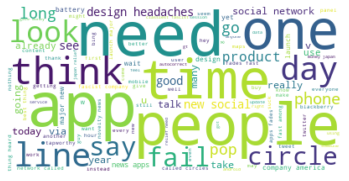

In [19]:
from wordcloud import WordCloud
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data

# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,

)
# generate the word cloud
wc.generate(negative_sentiment)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

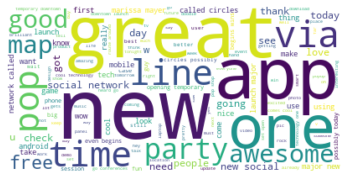

In [20]:
from wordcloud import WordCloud
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data

# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,

)
# generate the word cloud
wc.generate(positive_sentiment)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Train Test Split

In [21]:
df

,tweet_text,emotion_in_tweet_is_directed_at,emotion,label,processedtwitter
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1,"[g, hrs, tweeting, rise, dead, need, upgrade, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3,"[know, awesome, likely, appreciate, design, al..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1,"[hope, year, festival, crashy, year, app]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3,"[great, stuff, fri, marissa, mayer, tim, reill..."
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,3,"[pr, guy, convinced, switch, back, great, cove..."
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,3,"[papyrus, sort, like, nice, lol, lavelle]"
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,1,"[diller, says, tv, might, run, playstation, xb..."
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,3,"[always, used, camera, b, c, image, stabilizer..."


In [22]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = .9)

### Now to remove all of those @mentions

In [18]:
X_train['clean_tweet'] = X_train['tweet_text'].apply(remove_junk)


In [19]:
X_train['clean_tweet'] = X_train['clean_tweet'].apply(remove_nonASCII)

In [20]:
X_train["clean_tokens"] = X_train["clean_tweet"].apply(tokenize_sw)

In [21]:
#X_train["tweet_text"] = X_train["tweet_text"].str.lower()
#basic_token_pattern = r"(?u)\b\w\w+\b"

#tokenizer = RegexpTokenizer(basic_token_pattern)
#X_train["text_tokenized"] = X_train["tweet_text"].apply(tokenizer.tokenize)

In [22]:
X_train.drop(columns=['clean_tweet'], inplace=True)

In [23]:
X_train

,tweet_text,emotion_in_tweet_is_directed_at,emotion,processedtwitter
7888,So jealous of @mention who is at the team #and...,Android,Positive emotion,"[jealous, team, android, event, android, get, ..."
3951,Google's JS implementation of PAC-Man's game l...,Google,Positive emotion,"[js, implementation, pac, man, game, logic, re..."
8997,Data on my iPhone finally sorted. Next stop: #...,iPhone,Positive emotion,"[data, finally, sorted, next, stop]"
8721,Someone just held up iPad with giant LIKE on i...,iPad,Positive emotion,"[someone, held, giant, like, love]"
7356,"Ain't no party like a Google party, cause a Go...",Google,Positive emotion,"[party, like, party, cause, party, got, tacos,..."
...,...,...,...,...
5534,RT @mention Awesome hands on review of the iPa...,iPad,Positive emotion,"[awesome, hands, review, coming, tomorrow, gue..."
1282,"Apple Pop Up Store for #SXSW, Why not Pop Up G...",NaN,Positive emotion,"[pop, pop, genius, bars, everywhere]"
3910,They did it! Unlisted Apple Store suddenly app...,Apple,Positive emotion,"[unlisted, suddenly, appears, corner, th, cong..."
968,I can haz one? ÛÏ@mention Just showed off @me...,iPhone,Positive emotion,"[haz, one, showed, charge, anywhere, bar, char..."


In [24]:
from nltk import FreqDist

example_freq_dist = FreqDist(X_train.iloc[100]["processedtwitter"][:20])
example_freq_dist

FreqDist({'may': 1, 'gaining': 1, 'market': 1, 'share': 1, 'never': 1, 'know': 1, 'apparently': 1, 'industry': 1, 'movers': 1, 'shakers': 1, ...})

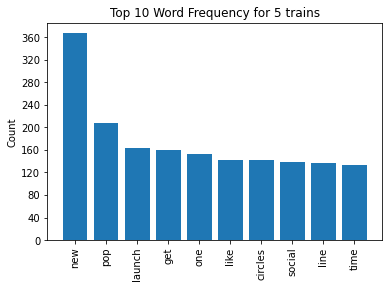

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
train_freq_dist = FreqDist(X_train['processedtwitter'].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for 5 trains")

In [26]:
X_train['emotion'].value_counts(normalize=True)

Positive emotion    0.839336
Negative emotion    0.160664
Name: emotion, dtype: float64

In [27]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(
    max_features=20,
    stop_words=stopwords,
    tokenizer=tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])


# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,amp,android,app,apple,austin,get,google,ipad,iphone,launch,like,link,mention,new,one,pop,quot,rt,store,sxsw
0,0.000000,0.645404,0.0,0.000000,0.0,0.6872,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.286381,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.170868
1,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.926821,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.375505
2,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.934444,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.356111
3,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.416311,0.000000,0.0,0.883780,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.213582
4,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.757297,0.000000,0.000000,0.0,0.634796,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.153411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.327699,0.000000,0.0,0.000000,0.000000,0.845334,0.0,0.000000,0.000000,0.0,0.386986,0.000000,0.168121
3189,0.000000,0.000000,0.0,0.273457,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.893775,0.0,0.000000,0.334967,0.119097
3190,0.521898,0.000000,0.0,0.637034,0.0,0.0000,0.000000,0.270394,0.000000,0.0,0.000000,0.277894,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.390164,0.138722
3191,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.284087,0.0,0.000000,0.000000,0.362909,0.0,0.880835,0.000000,0.0,0.000000,0.000000,0.108264


In [28]:
tfidf = TfidfVectorizer(max_features=25)
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,an,and,app,apple,at,for,google,in,ipad,iphone,...,new,of,on,quot,rt,store,sxsw,the,to,up
0,0.0,0.00000,0.0,0.000000,0.691961,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.419139,0.000000,0.0,0.000000,0.000000,0.158080,0.294993,0.000000,0.000000
1,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.413953,0.442776,0.000000,0.000000,...,0.0,0.444685,0.000000,0.0,0.000000,0.000000,0.167714,0.312973,0.353483,0.000000
2,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.502450,...,0.0,0.000000,0.562992,0.0,0.000000,0.000000,0.191249,0.000000,0.000000,0.000000
3,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.374175,0.000000,...,0.0,0.000000,0.523789,0.0,0.000000,0.000000,0.177931,0.000000,0.000000,0.535886
4,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.980092,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.198544,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,0.0,0.00000,0.0,0.000000,0.236051,0.000000,0.000000,0.000000,0.226805,0.000000,...,0.0,0.285965,0.634986,0.0,0.248258,0.000000,0.107853,0.201264,0.000000,0.000000
3189,0.0,0.00000,0.0,0.306857,0.000000,0.315072,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.375950,0.133577,0.000000,0.000000,0.804604
3190,0.0,0.00000,0.0,0.565234,0.000000,0.000000,0.000000,0.000000,0.258712,0.000000,...,0.0,0.326194,0.362158,0.0,0.000000,0.346252,0.123025,0.229578,0.000000,0.000000
3191,0.0,0.34538,0.0,0.000000,0.274589,0.000000,0.000000,0.000000,0.000000,0.329612,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.125461,0.234123,0.528855,0.000000


In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.83881064, 0.83881064, 0.83881064, 0.84012539, 0.84012539])

In [30]:
y_train.value_counts(normalize=True)

3    0.839336
1    0.160664
Name: label, dtype: float64

In [31]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [32]:
def doc_preparer(doc):
 
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [61]:
train_docs = [doc_preparer(doc) for doc in X_train['processedtwitter']]
test_docs = [doc_preparer(doc) for doc in X_test['processedtwitter']]

In [37]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.25, random_state=42)

In [40]:
cv = CountVectorizer(max_features=5)

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [43]:
# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [46]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8460575719649562

In [70]:
from sklearn.pipeline import Pipeline
#mapping = dict(zip(le.classes_, range(len(le.classes_))))
nb_pipe1 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', MultinomialNB())])

model = nb_pipe1.fit(train_docs, y_train)

pred  = model.predict(test_docs)

print(classification_report(y_test,
                            pred
                            ))

              precision    recall  f1-score   support

           1       1.00      0.05      0.10        57
           3       0.85      1.00      0.92       298

    accuracy                           0.85       355
   macro avg       0.92      0.53      0.51       355
weighted avg       0.87      0.85      0.79       355



In [86]:
from imblearn.pipeline       import Pipeline 
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score

nb_pipe2  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   MultinomialNB())])

nb_pipe2.fit(train_docs, y_train)
nb_pipe2.score(test_docs, y_test)

0.8366197183098592

In [87]:
y_trn_pred = nb_pipe2.predict(train_docs)
y_tst_pred = nb_pipe2.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))
    

		The Train Results
              precision    recall  f1-score   support

           1       0.69      0.98      0.81       513
           3       1.00      0.91      0.95      2680

    accuracy                           0.93      3193
   macro avg       0.84      0.95      0.88      3193
weighted avg       0.95      0.93      0.93      3193


		The Test Results
              precision    recall  f1-score   support

           1       0.49      0.70      0.58        57
           3       0.94      0.86      0.90       298

    accuracy                           0.84       355
   macro avg       0.72      0.78      0.74       355
weighted avg       0.87      0.84      0.85       355



In [92]:
from imblearn.over_sampling import SMOTE
nb_pipe2  = Pipeline([('vect',    CountVectorizer(ngram_range=(1, 3))),
                     ('tfidf',   TfidfTransformer()),
                     ('smt', SMOTE(random_state=42)),
                     ('model',   MultinomialNB())])

nb_pipe2.fit(train_docs, y_train)
nb_pipe2.score(test_docs, y_test)

0.8507042253521127

In [93]:
y_trn_pred = nb_pipe2.predict(train_docs)
y_tst_pred = nb_pipe2.predict(test_docs)
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           1       0.87      1.00      0.93       513
           3       1.00      0.97      0.99      2680

    accuracy                           0.98      3193
   macro avg       0.93      0.98      0.96      3193
weighted avg       0.98      0.98      0.98      3193


		The Test Results
              precision    recall  f1-score   support

           1       0.52      0.77      0.62        57
           3       0.95      0.87      0.91       298

    accuracy                           0.85       355
   macro avg       0.74      0.82      0.77       355
weighted avg       0.88      0.85      0.86       355

